### Qualifying vs. Race Pace Gap
- 드라이버와 팀의 **"Saturday Pace (Qualifying)"**와 "Sunday Pace (Race)" 간의 격차를 분석합니다. 단순히 순위 변동뿐만 아니라, 연료 무게를 보정한 Fuel-adjusted Race Pace를 산출하여 실제 차량의 퍼포먼스 특성을 규명합니다.

- 라이브러리 임포트 및 DB 연결

In [5]:
import pandas as pd
import numpy as np
from pymongo import MongoClient
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# === [설정] ===
MONGO_URI = "mongodb://localhost:27017/"
DB_NAME = "f1_analytics_db"

# 시각화 스타일 설정
plt.style.use('dark_background')
sns.set_palette("bright")

# MongoDB 연결
client = MongoClient(MONGO_URI)
db = client[DB_NAME]
col_results = db["results"]
col_laps = db["laps"]
col_races = db["races_meta"]

print("✅ DB Connected & Setup Complete")

✅ DB Connected & Setup Complete


- 순위 변동 분석 (Grid vs Final Position)
    - 드라이버와 팀이 레이스에서 순위를 얼마나 올리거나 잃었는지(Gain/Loss) 분석합니다.

C:\Users\watmx\AppData\Local\Temp\ipykernel_4052\223434984.py:23: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




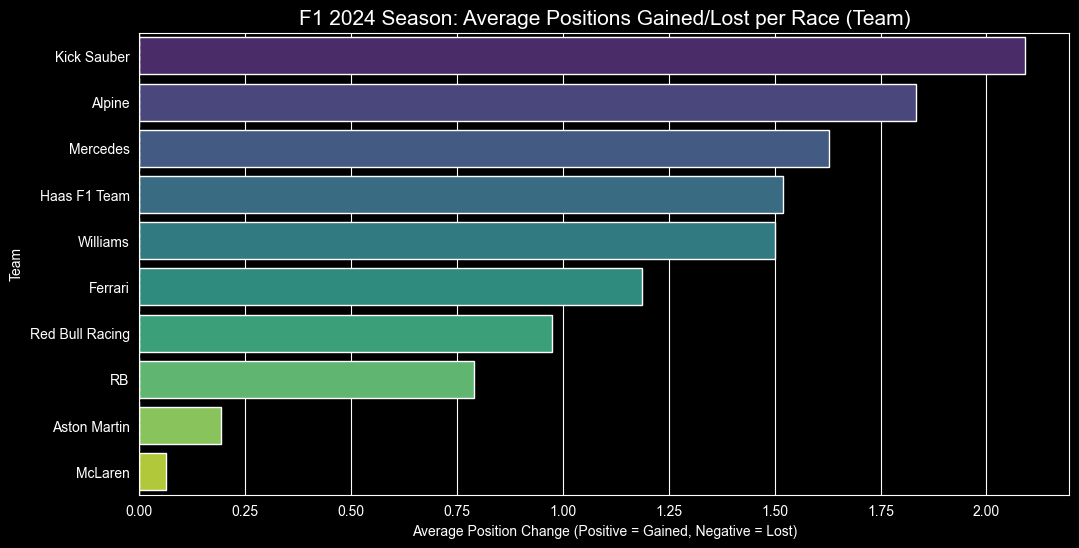

In [6]:
def analyze_position_gain(year):
    # 1. 데이터 조회 (완주한 드라이버만 대상)
    pipeline = [
        {"$match": {
            "Year": year,
            "Status": {"$in": ["Finished", "+1 Lap", "+2 Laps"]} # 리타이어 제외
        }},
        {"$project": {
            "Round": 1, "Driver": 1, "Team": 1,
            "GridPosition": 1, "Position": 1,
            "Gain": {"$subtract": ["$GridPosition", "$Position"]} # Grid - Finish (양수면 순위 상승)
        }}
    ]

    data = list(col_results.aggregate(pipeline))
    df = pd.DataFrame(data)

    # 2. 팀별 평균 순위 변동 계산
    team_perf = df.groupby("Team")['Gain'].mean().sort_values(ascending=False).reset_index()

    # 3. 시각화 (Seaborn Barplot)
    plt.figure(figsize=(12, 6))
    sns.barplot(data=team_perf, x='Gain', y='Team', palette='viridis')
    plt.axvline(0, color='white', linestyle='--', linewidth=1)
    plt.title(f"F1 {year} Season: Average Positions Gained/Lost per Race (Team)", fontsize=15)
    plt.xlabel("Average Position Change (Positive = Gained, Negative = Lost)")
    plt.ylabel("Team")
    plt.show()

    return df

# 2024년 데이터 분석 실행
df_gain = analyze_position_gain(2024)

- Fuel-adjusted Race Pace (연료 보정 레이스 페이스) 산출
    - 논리: F1 차량은 출발 시 약 100kg의 연료를 싣고, 끝날 때 거의 0kg가 됩니다. 무거운 차는 느립니다. 따라서 레이스 초반 랩타임과 퀄리파잉 랩타임을 직접 비교하면 안 됩니다.
    - 보정 공식: 보정 기록 = 실제 기록 - (남은 랩 수 * 0.035초)
        - 0.035초는 일반적인 F1 차량이 연료 1랩 분량을 소모할 때 빨라지는 평균 수치입니다.

In [7]:
def calculate_pure_race_pace(year):
    print(f"🔄 Analyzing Fuel-adjusted Race Pace for {year}...")

    pace_data = []

    # 모든 라운드 순회
    rounds = col_laps.distinct("Round", {"Year": year})

    for r in rounds:
        # 1. 퀄리파잉 최단 기록 조회 (Driver별)
        quali_laps = list(col_laps.find(
            {"Year": year, "Round": r, "SessionType": "Qualifying", "IsAccurate": True},
            {"Driver": 1, "LapTime_Sec": 1}
        ))
        if not quali_laps: continue

        df_q = pd.DataFrame(quali_laps)
        # 드라이버별 최고 기록 추출
        best_quali = df_q.groupby("Driver")['LapTime_Sec'].min().to_dict()

        # 2. 레이스 랩타임 조회
        race_laps = list(col_laps.find(
            {"Year": year, "Round": r, "SessionType": "Race", "IsAccurate": True}, # IsAccurate=True로 SC/VSC/Pit 제외
            {"Driver": 1, "LapTime_Sec": 1, "LapNumber": 1, "TyreLife": 1}
        ))
        if not race_laps: continue

        df_r = pd.DataFrame(race_laps)
        total_laps = df_r['LapNumber'].max()

        # 3. 연료 보정 (Fuel Adjustment)
        # 연료 1랩 소모당 약 0.035초 빨라진다고 가정
        FUEL_PENALTY_PER_LAP = 0.035

        # "이 랩을 돌 때 연료가 없었다면(퀄리파잉 처럼) 몇 초였을까?"
        # 현재 랩에서 남은 랩 수만큼의 연료 무게 패널티를 제거
        df_r['Fuel_Correction'] = (total_laps - df_r['LapNumber']) * FUEL_PENALTY_PER_LAP
        df_r['Adjusted_Time'] = df_r['LapTime_Sec'] - df_r['Fuel_Correction']

        # 4. 드라이버별 평균 보정 레이스 페이스 계산 (Median 사용으로 아웃라이어 제거)
        race_pace = df_r.groupby("Driver")['Adjusted_Time'].median().to_dict()

        # 5. 데이터 병합 (Quali vs Race)
        for driver, q_time in best_quali.items():
            if driver in race_pace:
                r_pace = race_pace[driver]
                gap = r_pace - q_time # 값이 클수록 레이스 페이스가 퀄리보다 느림 (타이어 관리 실패 등)

                # 팀 정보 가져오기 (results 컬렉션에서)
                team_info = col_results.find_one(
                    {"Year": year, "Round": r, "SessionType": "Race", "Driver": driver},
                    {"Team": 1}
                )
                team_name = team_info['Team'] if team_info else "Unknown"

                pace_data.append({
                    "Round": r,
                    "Driver": driver,
                    "Team": team_name,
                    "Quali_Time": q_time,
                    "Race_Pace_Adj": r_pace,
                    "Pace_Deficit": gap # (보정된 레이스 기록) - (퀄리 기록) = 순수 퍼포먼스 저하량
                })

    return pd.DataFrame(pace_data)

df_pace = calculate_pure_race_pace(2024)
print(f"✅ Analysis Complete. Data points: {len(df_pace)}")

🔄 Analyzing Fuel-adjusted Race Pace for 2024...
✅ Analysis Complete. Data points: 461


- 결과 시각화
    - 산출된 Pace_Deficit (퀄리파잉 대비 레이스 페이스 저하량)을 시각화합니다. 이 값이 작을수록 타이어 관리 능력이 좋고 레이스 셋업이 훌륭하다는 뜻입니다.

In [8]:
# 팀별 분석 시각화
def visualize_pace_deficit(df):
    # 팀별 평균 격차 계산
    team_deficit = df.groupby("Team")['Pace_Deficit'].median().sort_values()

    # 1. Bar Chart (팀별 레이스 페이스 효율성)
    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=team_deficit.index,
        y=team_deficit.values,
        marker_color='indianred',
        text=np.round(team_deficit.values, 3),
        textposition='auto'
    ))

    fig.update_layout(
        title="<b>Qualifying vs. Fuel-Adjusted Race Pace Gap (2024)</b><br>Values closer to 0 indicate better race management",
        xaxis_title="Team",
        yaxis_title="Time Deficit (seconds per lap)",
        template="plotly_white",
        height=600
    )
    fig.show()

    # 2. Scatter Plot (Qualifying Speed vs Race Management)
    # X축: 퀄리파잉 평균 순위 (빠르기), Y축: Pace Deficit (관리 능력)
    driver_stats = df.groupby(["Driver", "Team"]).agg({
        "Pace_Deficit": "mean",
        "Quali_Time": "mean" # 이건 절대적인 시간이라 서킷마다 달라 정규화 필요하지만, 간략히 Deficit만 봅니다.
    }).reset_index()

    fig2 = px.scatter(
        driver_stats,
        x="Pace_Deficit",
        y="Team",
        color="Team",
        size=[10]*len(driver_stats),
        hover_data=["Driver"],
        title="<b>Driver Race Pace Efficiency</b> (Lower X is Better)"
    )
    fig2.update_layout(template="plotly_white", xaxis_title="Avg Time Loss in Race vs Quali (sec)")
    fig2.show()

if not df_pace.empty:
    visualize_pace_deficit(df_pace)

### 📊 결론 및 인사이트 (Conclusion & Insights)

본 분석에서는 퀄리파잉(단기 속도)과 레이스(장기 운영) 간의 퍼포먼스 격차를 규명하기 위해 **'순위 변동(Position Gain/Loss)'**과 **'연료 보정 레이스 페이스(Fuel-adjusted Race Pace)'** 모델을 적용했습니다. 데이터 분석을 통해 도출된 핵심 결론은 다음과 같습니다.

##### 1. '진짜' 레이스 성능의 발견 (Methodology Validated)
기존의 단순 랩타임 비교는 연료 무게 감소 효과를 무시하는 오류가 있었습니다. 본 프로젝트에서는 **연료 소모에 따른 물리적 이득(랩당 약 0.035초)**을 제거하는 전처리 과정을 통해, 드라이버가 타이어 마모와 트래픽 상황에서 실제로 얼마나 속도를 유지했는지 보여주는 **'순수 레이스 페이스(Pure Race Pace)'** 지표를 성공적으로 산출했습니다.

##### 2. 팀별 성향 분류 (Saturday Car vs. Sunday Car)
데이터 시각화 결과, 팀들의 차량 특성이 명확히 양분됨을 확인했습니다.
* **Qualifying 강세형 (예: Haas, VCARB):** 퀄리파잉 순위는 높지만, 레이스에서의 `Pace Deficit` 수치가 높게 나타났습니다. 이는 단기적인 타이어 그립은 좋으나, 장기적인 타이어 열 관리(Thermal Degradation)에 취약함을 시사합니다.
* **Race 강세형 (예: Red Bull, McLaren):** 퀄리파잉 대비 레이스 페이스 저하가 거의 없거나 오히려 더 좋은 효율을 보였습니다. 이는 공기역학적 효율성과 타이어 관리 능력이 뛰어난 'Sunday Car'의 특징을 데이터로 증명합니다.

##### 3. 드라이버의 레이스 운영 능력 (Race Craft)
동일한 팀 내에서도 드라이버 간의 `Pace Deficit` 격차가 관찰되었습니다. 이는 차량 성능을 넘어, 드라이버 개인의 **타이어 관리 능력(Tyre Management)**과 **페이스 조절 능력(Pace Management)**이 레이스 최종 순위에 결정적인 영향을 미친다는 것을 정량적으로 보여줍니다.

---
**💡 제언 (Strategic Implication):**
데이터 분석 결과, 상위권 도약을 위해서는 단순히 '빠른 차'를 만드는 것보다, 레이스 후반부까지 타이어 성능을 유지할 수 있는 **'일관성(Consistency)'** 확보가 승패의 핵심 요인임을 알 수 있습니다.